In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy import stats
# import FinanceDataReader as fdr
import seaborn as sns
from Regime_TDF_utils import *
from utils import *
%matplotlib inline
plt.style.use('ggplot')
# plt.patch.set_facecolor('lightgrey')

# 분석 내용
* 논문 `<Target-Date Funds: A Regime-Based Approach, Kritzman(2017)>`에서 소개된 Regime-based TDF 전략을 국내 시장에도 적용하였다.
* 데이터
    * daily data를 사용한다.
    * 국내 산업군 수익률 및 3년물 채권 수익률 데이터는 FnGuide를 참고하였다.
    * weekly returns과 monthly returns은 daily returns으로부터 계산하였다.


In [22]:
# # df_bond = pd.read_csv("../data/kr_3yr_bond_daily.csv", index_col=0, parse_dates=True)
# # df_bond = (1+df_bond/252/100).cumprod()
# df_bond = pd.read_csv("../data/kr_govt_bond_and_commodity.csv", index_col=0,parse_dates=True)[["govt bond"]]/100
# ret_bond = df_bond.copy() # 채권 수익률 데이터
# df_bond = (1+df_bond).cumprod() # 채권 가격 데이터
# df_comm = pd.read_csv("../data/kr_govt_bond_and_commodity.csv", index_col=0,parse_dates=True)[["commodity"]]/100
# ret_comm = df_comm.copy() # 원자재 수익률 데이터
# df_comm = (1+df_comm).cumprod() # 원자재 가격 데이터
# df_kospi = pd.read_csv("../data/KS11.csv", index_col=0, parse_dates=True) # 코스피지수 가격데이터
# df_price = pd.read_csv("../data/kospi_industry_daily.csv", index_col=0, parse_dates=True) # 산업지수가격데이터
# # np.random.seed(1)
# # rnd = np.random.choice(df_price.columns, 18-8, replace=False)
# df_price = df_price.drop(["insurance", "banking", "finance", "securities"], axis=1)
# # df_price = df_price.drop(rnd, axis=1)

In [23]:
df_bond = pd.read_excel("../data/kritzman_data.xlsx", sheet_name="bond", index_col=0, parse_dates=True)
df_comm = pd.read_excel("../data/kritzman_data.xlsx", sheet_name="commodity", index_col=0, parse_dates=True)
df_factor = pd.read_excel("../data/kritzman_data.xlsx", sheet_name="factor", index_col=0, parse_dates=True)
df_industry = pd.read_excel("../data/kritzman_data.xlsx", sheet_name="industry", index_col=0, parse_dates=True)
df_eqindex = pd.read_excel("../data/kritzman_data.xlsx", sheet_name="asia equity index", index_col=0, parse_dates=True)

In [24]:
ret_kospi = df_eqindex[["KS11"]].pct_change().dropna()
ret_industry = df_industry.pct_change().dropna()
ret_bond = df_bond.pct_change().dropna()
ret_eqindex = df_eqindex.pct_change()

In [25]:
ret_kospi = ret_kospi.apply(drop_outliers)
ret_industry = ret_industry.apply(drop_outliers)

In [26]:
pd.concat([ret_kospi, ret_industry, ret_eqindex, ret_bond], axis=1).describe()

,KS11,Energy,Materials,Industrials,Con Disc,Con Staples,Health Care,Financials,IT,TCS,Utilities,N225,SSEC,HSI,KS11,KQ11,bond_tot_ret
count,10103.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,10103.000000,4872.000000,10103.000000,10103.000000,5852.000000,3784.000000
mean,0.000391,0.000720,0.000472,0.000466,0.000442,0.000534,0.000783,0.000299,0.000555,0.000050,0.000224,0.000193,0.000272,0.000419,0.000391,0.000075,0.000161
std,0.014951,0.021216,0.017588,0.017577,0.014210,0.012275,0.017054,0.017110,0.016506,0.013156,0.016381,0.013395,0.015582,0.015925,0.014951,0.017513,0.001228
min,-0.120188,-0.128628,-0.136441,-0.135329,-0.097669,-0.058044,-0.099674,-0.121410,-0.134013,-0.058733,-0.118240,-0.118877,-0.088407,-0.333305,-0.120188,-0.115858,-0.008193
25%,-0.005678,-0.010172,-0.009026,-0.008256,-0.006923,-0.006587,-0.008279,-0.008116,-0.008499,-0.007775,-0.008930,-0.005259,-0.006259,-0.005571,-0.005678,-0.006542,-0.000356
50%,0.000000,0.000177,0.000559,0.000675,0.000574,0.000573,0.000806,-0.000316,0.000612,-0.000415,-0.000297,0.000000,0.000023,0.000000,0.000000,0.000885,0.000135
75%,0.006583,0.010829,0.010218,0.009698,0.008121,0.007947,0.009823,0.008606,0.009675,0.007455,0.008608,0.006095,0.007105,0.007119,0.006583,0.008029,0.000713
max,0.119457,0.186014,0.147275,0.140731,0.120806,0.064504,0.086642,0.115371,0.134530,0.076486,0.141728,0.141503,0.098568,0.188237,0.119457,0.114688,0.008058


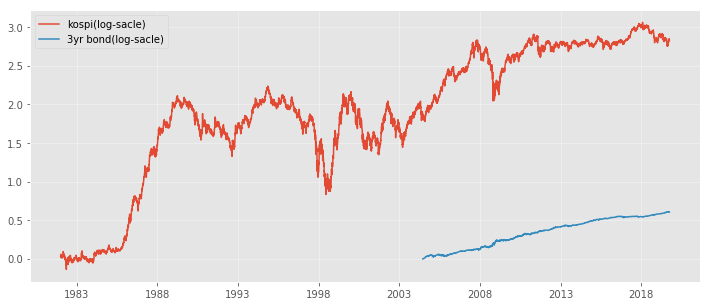

In [30]:
plt.figure(figsize=(12,5))
plt.plot(np.log((1+ret_kospi)).cumsum(), label="kospi(log-sacle)")
# plt.plot(np.log(1+ret_industry).cumsum())
plt.plot(np.log(1+df_bond.pct_change()).cumsum(), label="3yr bond(log-sacle)")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

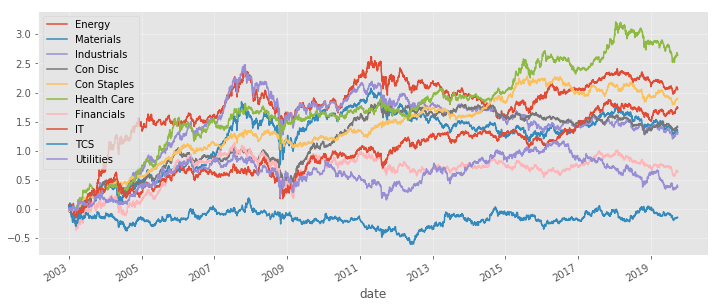

In [31]:
np.log(1+ret_industry).cumsum().plot(figsize=(12,5))
plt.legend()
plt.grid(alpha=0.4)
plt.show()

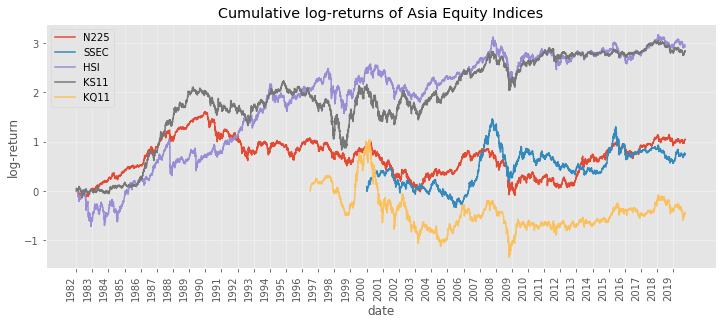

In [32]:
np.log(1+ret_eqindex).cumsum().plot(figsize=(12,5))
plt.xticks(ret_eqindex.resample("BYS").first().index, rotation=90)
plt.title("Cumulative log-returns of Asia Equity Indices")
plt.ylabel("log-return")
plt.grid(alpha=0.4)
plt.show()

In [33]:
L = 0
Z = -1.645
horizon = [20, 15, 10, 5, 1]
mu_risky = 0.075
vol_risky = 0.21
mu_safe = 0.025

risky_weight = [cal_weight_risky(L=L, T=T, Z=Z, mu_safe=mu_safe, mu_risky=mu_risky, vol_risky=vol_risky) for T in horizon]
safe_weight = 1 - np.array(risky_weight)
result = pd.DataFrame({"Risky":risky_weight, "Safe":safe_weight}, index=horizon)
result.index.name = "Yrs to Invest"
result.columns = [["Asset Mix", "Asset Mix"], ["Risky", "Safe"]]


In [34]:
result.round(3)

Asset Mix       
                  Risky   Safe
Yrs to Invest                 
20                0.918  0.082
15                0.638  0.362
10                0.422  0.578
5                 0.239  0.761
1                 0.085  0.915

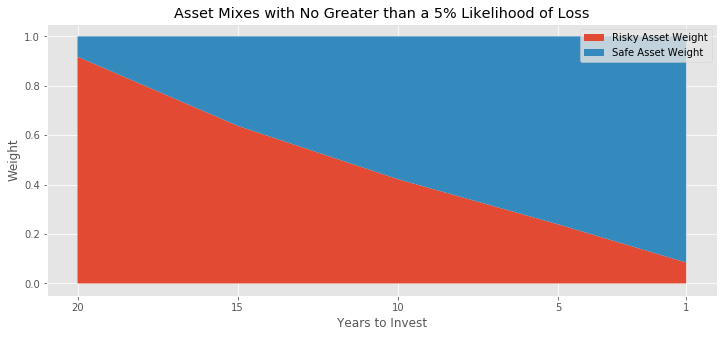

In [35]:
plt.figure(figsize=(12,5))
plt.fill_between(horizon, 0, risky_weight, label="Risky Asset Weight")
plt.fill_between(horizon, risky_weight, 1, label="Safe Asset Weight")
plt.xticks(horizon)
plt.gca().invert_xaxis()
plt.xlabel("Years to Invest")
plt.ylabel("Weight")
plt.title("Asset Mixes with No Greater than a 5% Likelihood of Loss")
plt.legend()
plt.show()

# Trailing 12-Month Volatility

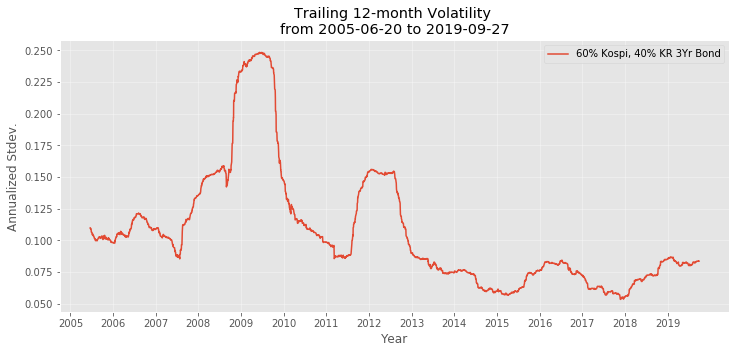

In [36]:
df_return_SixFour = pd.concat([ret_kospi, ret_bond], axis=1, join="inner").fillna(0).dropna()
df_return_SixFour = (df_return_SixFour * np.array([0.6, 0.4])).sum(axis=1) # Not Buy-and-Hold
df_rolling_stdev = df_return_SixFour.rolling(window=252, min_periods=252).std().dropna() * np.sqrt(252)

plt.figure(figsize=(12,5))
xticks = df_rolling_stdev.resample("YS").first().index
plt.plot(df_rolling_stdev, label="60% Kospi, 40% KR 3Yr Bond")
plt.xticks(xticks)
index = df_rolling_stdev.index
plt.title("Trailing 12-month Volatility \nfrom {} to {}".format(index[0].date(), index[-1].date()))
plt.ylabel("Annualized Stdev.")
plt.xlabel("Year")
plt.legend()
plt.grid(alpha=0.4)

In [37]:
mean = df_return_SixFour.mean() * 252
avg_stdev = np.round(df_rolling_stdev.mean(), 3)
min_stdev = np.round(df_rolling_stdev.min(), 3)
max_stdev = np.round(df_rolling_stdev.max(), 3)

L = 0
T = [20, 15, 10, 5, 1]

pol_avg = [cal_prob_of_loss(L=L, T=i, mu_safe=0, mu_risky=mean, vol_risky=avg_stdev, weight_risky=1) for i in T]
pol_min = [cal_prob_of_loss(L=L, T=i, mu_safe=0, mu_risky=mean, vol_risky=min_stdev, weight_risky=1) for i in T]
pol_max = [cal_prob_of_loss(L=L, T=i, mu_safe=0, mu_risky=mean, vol_risky=max_stdev, weight_risky=1) for i in T]

result = pd.DataFrame({"{}%".format(min_stdev*100):np.round(pol_min, 3),
                      "{0:.1f}%".format(avg_stdev*100):np.round(pol_avg, 3),
                      "{}%".format(max_stdev*100):np.round(pol_max, 3),},
                      index=T)
result.index.name = "Yrs to Invest"
result.columns = [["Annualized Stdev.", "Annualized Stdev.", "Annualized Stdev."], result.columns]

print("Expected Return = {0:.3f}%".format(mean*100))
print("--------------------------")
print("Probability of Loss(<0%)")

result

Expected Return = 6.747%
--------------------------
Probability of Loss(<0%)


Annualized Stdev.              
                           5.3%  10.6%  24.8%
Yrs to Invest                                
20                        0.000  0.002  0.112
15                        0.000  0.007  0.146
10                        0.000  0.022  0.195
5                         0.002  0.077  0.271
1                         0.101  0.262  0.393

In [38]:
ret_data = ret_industry.copy()
turb = cal_turbulence(ret_data)
turb.mean()

0.9950248756218911

In [39]:
ret_data.head(2)

,Energy,Materials,Industrials,Con Disc,Con Staples,Health Care,Financials,IT,TCS,Utilities
date,,,,,,,,,,
2003-01-03,0.0155,0.036150,0.045730,0.051690,0.008660,0.021350,0.041740,0.064460,0.035820,0.001700
2003-01-06,0.0000,0.019524,-0.001693,0.011077,-0.004362,0.000979,0.006249,0.015228,0.004315,0.015923


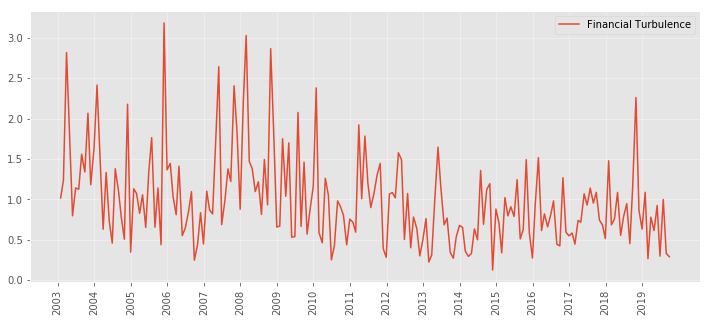

In [40]:
plt.figure(figsize=(12,5))

xticks = turb.resample("BYS").first().index
plt.plot(turb, label="Financial Turbulence")
plt.xticks(xticks, rotation=90)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

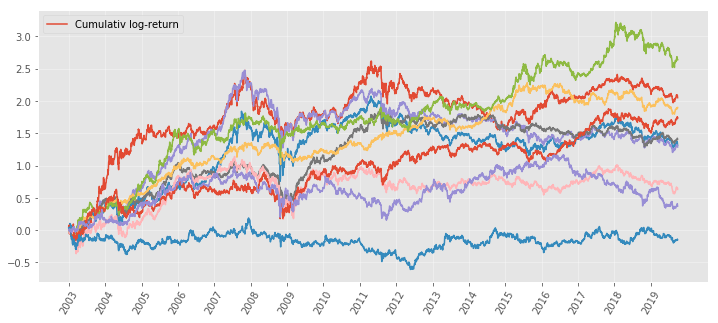

In [41]:
plt.figure(figsize=(12,5))
# plt.plot(np.log(1+ret_industry).cumsum(), label=None)
plt.plot(np.log(1+ret_data).cumsum(), label=None)
plt.xticks(xticks, rotation=60)
plt.legend(["Cumulativ log-return"])
plt.grid(alpha=0.4)
plt.show()

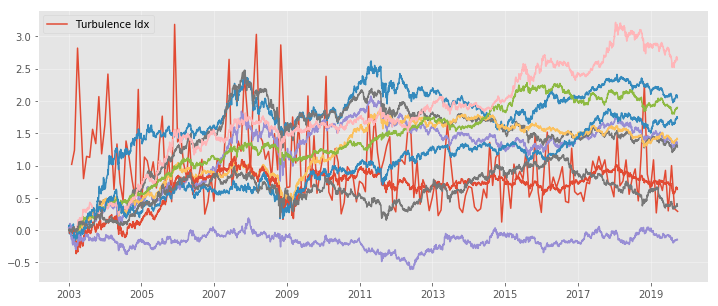

In [42]:
plt.figure(figsize=(12,5))
plt.plot(turb, label="Turbulence Idx")
plt.plot(np.log(1+ret_data).cumsum())
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [43]:
q = 0.9 
criterion = turb.quantile(q=q) # set a cut point

mkt_turb = turb[turb>=criterion].index.to_period("m").strftime("%Y-%m") # Months with turbulence value above "q" quantile.
mkt_calm = turb[turb<criterion].index.to_period("m").strftime("%Y-%m") # Months with turbulence value below "q" quantile.

ret_turb_period = pd.DataFrame()
for i in mkt_turb:
    ret_turb_period = pd.concat([ret_turb_period, ret_data[i]], axis=0) # returns during turbulence periods.
    
ret_calm_period = pd.DataFrame()
for i in mkt_calm:
    ret_calm_period = pd.concat([ret_calm_period, ret_data[i]], axis=0) # returns during non-turbulence periods.

In [44]:
turb_corr = ret_turb_period.corr()
turb_mean = ret_turb_period.mean() * 252
turb_mean.name = "Mean"
turb_std = ret_turb_period.std() * np.sqrt(252)
turb_std.name = "Stdev."

calm_corr = ret_calm_period.corr()
calm_mean = ret_calm_period.mean() * 252
calm_mean.name = "Mean"
calm_std = ret_calm_period.std() * np.sqrt(252)
calm_std.name = "Stdev."

corr_diff = turb_corr - calm_corr
mask = np.ones_like(corr_diff)
mask[np.triu_indices_from(mask)] = np.nan
corr_diff = corr_diff*mask
mean_diff = turb_mean - calm_mean
std_diff = turb_std - calm_std

df_difference = pd.concat([mean_diff, std_diff, corr_diff], axis=1)

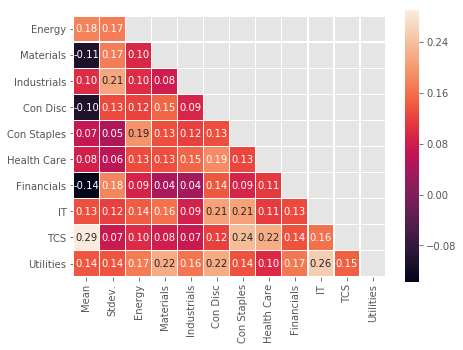

In [45]:
plt.figure(figsize=(7,5))
sns.heatmap(df_difference, annot=True, square=True, linewidths=.4, fmt="0.2f")
plt.show()

In [46]:
# q = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95]
# for i in q:
#     criterion = turb.quantile(q=i)
#     mkt_turb = turb[turb>=criterion].index.to_period("m").strftime("%Y-%m")
#     mkt_calm = turb[turb<criterion].index.to_period("m").strftime("%Y-%m")
    
#     ret_tub_period = pd.DataFrame()
#     for j in mkt_turb:
#         ret_turb_period = pd.concat([ret_turb_period, ret_industry[j]], axis=0)

#     ret_calm_period = pd.DataFrame()
#     for k in mkt_calm:
#         ret_calm_period = pd.concat([ret_calm_period, ret_industry[k]], axis=0)
        
#     turb_corr = ret_turb_period.corr()
#     turb_mean = ret_turb_period.mean() * 252
#     turb_mean.name = "Mean"
#     turb_std = ret_turb_period.std() * np.sqrt(252)
#     turb_std.name = "Stdev."

#     calm_corr = ret_calm_period.corr()
#     calm_mean = ret_calm_period.mean() * 252
#     calm_mean.name = "Mean"
#     calm_std = ret_calm_period.std() * np.sqrt(252)
#     calm_std.name = "Stdev."

#     corr_diff = turb_corr - calm_corr
#     mask = np.ones_like(corr_diff)
#     mask[np.triu_indices_from(mask)] = np.nan
#     corr_diff = corr_diff*mask
#     mean_diff = turb_mean - calm_mean
#     std_diff = turb_std - calm_std

#     df_difference = pd.concat([mean_diff, std_diff, corr_diff], axis=1)
    
#     aa = pd.DataFrame([turb_mean, turb_std]).T
#     aa = aa.append(pd.Series(aa.mean(), name="Total"))
#     aa.columns = [["q={}".format(i), "q={}".format(i)], ["Mean", "Stdev."]]
#     aa.to_excel("diff/mu_std for q={}.xlsx".format(i))

In [47]:
# q = 0.9

# mask = np.zeros_like(ret_data.corr())
# mask[np.triu_indices_from(mask)] = True

# plt.figure(figsize=(7,5))
# plt.title("Total Period")
# sns.heatmap(ret_data.corr(), center=0, mask=mask, annot=True, square=True, linewidths=.4, fmt="0.2f")

# mask = np.zeros_like(turb_corr)
# mask[np.triu_indices_from(mask)] = True

# plt.figure(figsize=(7,5))
# plt.title("turbulence (q={})".format(q))
# sns.heatmap(turb_corr, center=0, mask=mask, annot=True, square=True, linewidths=.4, fmt="0.2f")

# mask = np.zeros_like(calm_corr)
# mask[np.triu_indices_from(mask)] = True

# plt.figure(figsize=(7,5))
# plt.title("non-turbulence (q={})".format(q))
# sns.heatmap(calm_corr, center=0, mask=mask, annot=True, square=True, linewidths=.4, fmt="0.2f")

# mask = np.zeros_like(corr_diff)
# mask[np.triu_indices_from(mask)] = True

# plt.figure(figsize=(7,5))
# plt.title("difference (q={})".format(q))
# sns.heatmap(corr_diff, center=0, mask=mask, annot=True, square=True, linewidths=.4, fmt="0.2f")

## Absorption Ratio (rolling, window=500)

In [48]:
ar_index = cal_absorption_ratio_rolling(ret_data, frac=0.3, decay=0.97, window=500)

## turbulence daily (rolling, window=500)

In [49]:
date_index = ret_data.index
ret_aggregate = pd.concat([ret_data, ret_eqindex], axis=1, join="outer").loc[date_index[0]:date_index[-1]]
ret_aggregate.isnull().sum()
ret_asia = ret_aggregate.iloc[:,10:]

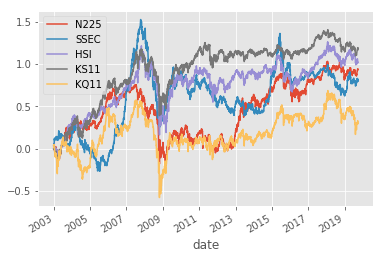

In [50]:
np.log(1+ret_aggregate.iloc[:,10:]).cumsum().plot(legend=True)

In [51]:
# tb_index = cal_turbulence_rolling(ret_data, window=500) # 10개 산업지수
tb_index = cal_turbulence_rolling(ret_aggregate, window=500) # 10개 산업지수 + 5개 아시아 주가지수(코스피, 상해종합, 항셍, 니케이)
# tb_index = cal_turbulence_rolling(ret_asia, window=500) # 5개 아시아 주가지수

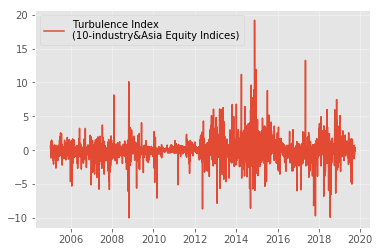

In [52]:
label = "Turbulence Index\n(10-industry&Asia Equity Indices)"
plt.figure()
plt.plot(tb_index, label=label)
plt.grid(alpha=0.4)
plt.legend(loc="upper left")
plt.show()

## turbulence index (full sampling) - 나중에 비교하기 위해서 계산해놓음


In [53]:
# nassets = len(ret_data.columns)
# mean = ret_data.mean()
# invcov = np.linalg.inv(ret_data.cov())
# tb_fullsample = [(1/nassets) * (ret_data.loc[i]-mean)@invcov@(ret_data.loc[i]-mean) for i in ret_data.index]
# tb_fullsample = pd.DataFrame(tb_fullsample, columns=["tb(fullsample)"], index=ret_data.index)

In [54]:
# tb_fullsample.plot()

## Regime indicator를 표준화스러운 작업을 해줌
* turbulence index는 5일 단기평균에 대해 252일 장기평균 및 표준편차로 표준화시킴.
* absorption ratio index 역시 같은 방식으로 표준화시킴.

In [55]:
long = 252 # 장기
short = 5  # 단기

tb_zscore = (tb_index.rolling(window=short).mean() - tb_index.rolling(window=long).mean()) / tb_index.rolling(window=long).std()
tb_zscore = tb_zscore.dropna()

ar_zscore = (ar_index.rolling(window=short).mean() - ar_index.rolling(window=long).mean()) / ar_index.rolling(window=long).std()
ar_zscore = ar_zscore.dropna()

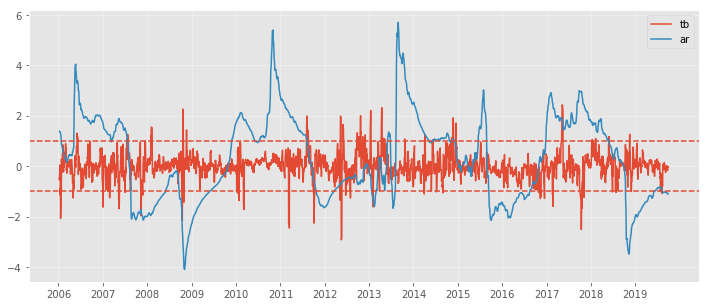

In [56]:
plt.figure(figsize=(12,5))
plt.plot(tb_zscore, label="tb")
plt.plot(ar_zscore, label="ar")
plt.axhline(y=1, ls="--")
plt.axhline(y=-1, ls="--")
plt.xticks(tb_zscore.resample("BYS").first().index)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

## Identifying market regimes.

In [57]:
tb_abs = np.abs(tb_zscore)
ar_abs = np.abs(ar_zscore)

df_signal = pd.concat([tb_abs, ar_abs], axis=1).dropna()

In [58]:
df_signal.isnull().sum()

turbulence          0
absorption ratio    0
dtype: int64

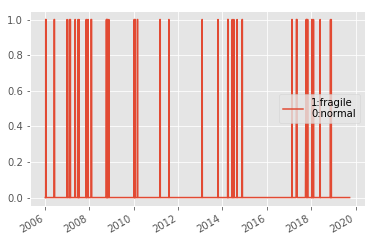

In [59]:
fragile_boo = pd.DataFrame((df_signal["turbulence"]>1) & (df_signal["absorption ratio"]>1), columns=["fragile"])
fragile_boo = fragile_boo.astype(int)
fragile_boo.plot()
plt.legend(["1:fragile\n0:normal"])
plt.show()

In [60]:
print("the number of fragile regime signals: {}".format(len(fragile_boo[fragile_boo["fragile"] == 1])))
print("the number of normal regime signals: {}".format(len(fragile_boo[fragile_boo["fragile"] == 0])))

the number of fragile regime signals: 101
the number of normal regime signals: 3288


## Asset Allocation Process

In [61]:
# 1/n 포트폴리오의 평균 및 변동성
total_mean = ret_industry.mean(axis=1).mean() * 252
total_vol = ret_industry.mean(axis=1).std() * np.sqrt(252)
turb_vol = ret_turb_period.mean(axis=1).std() * np.sqrt(252)
normal_vol = ret_calm_period.mean(axis=1).std() * np.sqrt(252)
print("total mean:{} \ntotal stdev.:{} \nfragile stdev.:{} \nnormal stdev.:{}".format(total_mean, total_vol, turb_vol, normal_vol))

total mean:0.11449481675066873 
total stdev.:0.1803311988604516 
fragile stdev.:0.287154962874972 
normal stdev.:0.16300614815642597


In [62]:
# 채권의 평균 표준편차
bond_mean = ret_bond.values.mean() * 252
bond_mean = np.round(bond_mean, 3)
bond_vol = ret_bond.values.std() * np.sqrt(252)
bond_vol = np.round(bond_vol, 3)
print("{:.1f}% / {}%".format(bond_mean*100, bond_vol*100))

4.1% / 1.9%


### Conventional Asset Allocation

In [63]:
mu_safe = bond_mean
mu_risky = np.round(total_mean, 3)
vol_risky = np.round(total_vol, 3)

print("mu_safe:{} / mu_risky:{} / vol_risky:{}".format(mu_safe, mu_risky, vol_risky))

start_year = fragile_boo.index.year[0]
end_year = fragile_boo.index.year[-1]

df_allocation = pd.DataFrame()
for i in np.arange(end_year-start_year+1,0,-1):
    risky_weight = np.round(cal_weight_risky(L=0, T=i, Z=-2.33, mu_safe= mu_safe, mu_risky=mu_risky, vol_risky=vol_risky), 3)
    if risky_weight > 1:
        risky_weight = 1
    safe_weight = 1 - risky_weight
    df_allocation.loc[i,"risky_weight"] = risky_weight
    df_allocation.loc[i,"safe_weight"] = safe_weight

mu_safe:0.041 / mu_risky:0.114 / vol_risky:0.18


In [64]:
df_allocation

,risky_weight,safe_weight
14,1.000,0.000
13,0.946,0.054
12,0.853,0.147
11,0.767,0.233
10,0.688,0.312
9,0.614,0.386
8,0.545,0.455
7,0.479,0.521
6,0.417,0.583
5,0.358,0.642


In [65]:
df_date = pd.DataFrame(fragile_boo.index, columns=["date"], index=fragile_boo.index)
firstdayofyear = df_date.resample("BYS").first().set_index("date")

df_allocation.index = fragile_boo.resample("BYS").first().index
df_allocation.index = firstdayofyear.index
df_allocation

,risky_weight,safe_weight
date,,
2006-01-11,1.000,0.000
2007-01-02,0.946,0.054
2008-01-02,0.853,0.147
2009-01-02,0.767,0.233
2010-01-04,0.688,0.312
2011-01-03,0.614,0.386
2012-01-02,0.545,0.455
2013-01-02,0.479,0.521
2014-01-02,0.417,0.583


In [66]:
weight_info = pd.concat([df_allocation,fragile_boo], axis=1)
weight_info["date"] = weight_info.index
weight_info.head()

,risky_weight,safe_weight,fragile,date
2006-01-11,1.0,0.0,0,2006-01-11
2006-01-12,NaN,NaN,0,2006-01-12
2006-01-13,NaN,NaN,0,2006-01-13
2006-01-16,NaN,NaN,0,2006-01-16
2006-01-17,NaN,NaN,0,2006-01-17


### Dynamic Asset Allocation
* Trading Ban Rule : 5days

In [67]:
trading_ban = 5
date_index = weight_info["date"]

mu_safe = ret_bond.values.mean().astype(float) * 252
mu_risky = ret_industry.mean(axis=1).mean() * 252

fragile_vol = ret_turb_period.mean(axis=1).std() * np.sqrt(252)
# normal_vol = ret_calm_period.mean(axis=1).std() * np.sqrt(252)
normal_vol = ret_industry.mean(axis=1).std() * np.sqrt(252)

print("mu_safe:{}, mu_risky:{}, fragile_vol:{}, normal_vol:{}".format(mu_safe, mu_risky, fragile_vol, normal_vol))

invest_start_year = weight_info.index.year[0]
invest_end_year = weight_info.index.year[-1]

weight_info.loc[:,["risky_weight","safe_weight"]] = 0

L = 0
Z = -2.33
for num, i in enumerate(weight_info["date"]):
    year = i.year
    month = i.month
    day = i.day
    
    horizon = invest_end_year-year+1
#     print(horizon)
    if weight_info.loc[i,"risky_weight"] == 0: # 가중치 부여가 안되어 있다면, 
        ban = date_index[num:num+trading_ban][-1] # 그날로부터 trading-ban 규칙에 따라 x일 동안까지,
#         print(horizon)
        if weight_info.loc[i,"fragile"] == 0: # 만약 normal regime이라면
            
            # 평균변동성으로 위험자산의 가중치 계산하고
            risky_weight = cal_weight_risky(L=L, T=horizon, Z=Z, mu_safe=mu_safe, mu_risky=mu_risky, vol_risky=normal_vol)
            if risky_weight > 1: # 만약 그 가중치가 1이 넘는다면 1로 cap 씌워주고
                risky_weight = 1
            elif risky_weight < 0:
                risky_weight = 0
            weight_info.loc[i:ban, "risky_weight"] = risky_weight # 포지션 유지기간 동안 동일한 가중치 부여.
        
        else: # 만약 그날이 fragile regime이라면
            risky_weight = cal_weight_risky(L=L, T=horizon, Z=Z, mu_safe=mu_safe, mu_risky=mu_risky, vol_risky=fragile_vol)
            if risky_weight > 1:
                risky_weight = 1
            elif risky_weight < 0:
                risky_weight = 0
            weight_info.loc[i:ban, "risky_weight"] = risky_weight
    else: # 가중치가 부여되어 있다면 가중치 부여가 안되어있는 날까지 넘어가자.
        pass
weight_info.loc[:,"safe_weight"] = 1-weight_info.loc[:,"risky_weight"]

mu_safe:0.040538482755073775, mu_risky:0.11449481675066873, fragile_vol:0.287154962874972, normal_vol:0.1803311988604516


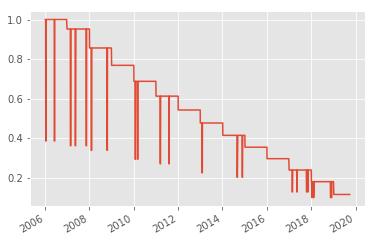

In [68]:
weight_info["risky_weight"].plot()

In [69]:
weight_info.head()

,risky_weight,safe_weight,fragile,date
2006-01-11,1.0,0.0,0,2006-01-11
2006-01-12,1.0,0.0,0,2006-01-12
2006-01-13,1.0,0.0,0,2006-01-13
2006-01-16,1.0,0.0,0,2006-01-16
2006-01-17,1.0,0.0,0,2006-01-17


In [70]:
ret_risky = ret_industry.mean(axis=1).loc[weight_info.index[0]:,]
ret_safe = ret_bond.mean(axis=1).loc[weight_info.index[0]:,]

In [71]:
weight_convention = pd.concat([df_allocation, fragile_boo], axis=1).fillna(method="ffill")
pfo_convention = ret_risky*weight_convention["risky_weight"] + ret_safe*weight_convention["safe_weight"]
pfo_regime = ret_risky*weight_info["risky_weight"] + ret_safe*weight_info["safe_weight"]

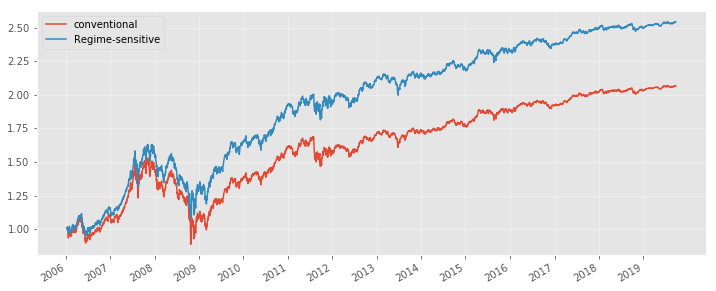

In [72]:
plt.figure(figsize=(12,5))
(1+pfo_convention).cumprod().plot(label="conventional")
(1+pfo_regime).cumprod().plot(label="Regime-sensitive")
plt.xticks(pfo_convention.resample("BYS").first().index)
plt.grid(alpha=0.4)
plt.legend()

In [73]:
result_df = pd.concat([pfo_convention, pfo_regime], axis=1)
result_df.columns = ["conventional", "regime-sensitvie"]
get_total_performance(result_df, risk_free=0.02)

,MDD,Sharpe ratio,VaR,Profit loss ratio,Winning ratio,Calmar ratio,Mean,Std,Total return
conventional,0.419470,0.329686,-0.013005,0.946013,0.540413,0.100515,0.062163,0.127907,1.062142
regime-sensitvie,0.335894,0.464770,-0.012352,0.966144,0.542478,0.169022,0.076774,0.122172,1.534827


### What if Buy-and-Hold?

### 1. Regime-sensitive 

In [74]:
trading_ban = 5
date_index = weight_info["date"]

mu_safe = ret_bond.values.mean().astype(float) * 252
mu_risky = ret_industry.mean(axis=1).mean() * 252

fragile_vol = ret_turb_period.mean(axis=1).std() * np.sqrt(252)
# normal_vol = ret_calm_period.mean(axis=1).std() * np.sqrt(252)
normal_vol = ret_industry.mean(axis=1).std() * np.sqrt(252)

print("mu_safe:{}, mu_risky:{}, fragile_vol:{}, normal_vol:{}".format(mu_safe, mu_risky, fragile_vol, normal_vol))

invest_start_year = weight_info.index.year[0]
invest_end_year = weight_info.index.year[-1]

weight_info.loc[:,["risky_weight","safe_weight"]] = np.nan

L = 0
Z = -2.33
ban = weight_info["date"][0] + relativedelta(days=-1)
for num, i in enumerate(weight_info["date"]):
    year = i.year
    month = i.month
    day = i.day
    
    horizon = invest_end_year-year+1
    if i <= ban:
        continue
    if np.isnan(weight_info.loc[i,"risky_weight"]): # 가중치 부여가 안되어 있다면, 
        ban = date_index[num:num+trading_ban][-1] # 그날로부터 trading-ban 규칙에 따라 x일 동안까지,
#         print(horizon)
        if weight_info.loc[i,"fragile"] == 0: # 만약 normal regime이라면
            
            # 평균변동성으로 위험자산의 가중치 계산하고
            risky_weight = cal_weight_risky(L=L, T=horizon, Z=Z, mu_safe=mu_safe, mu_risky=mu_risky, vol_risky=normal_vol)
            if risky_weight > 1: # 만약 그 가중치가 1이 넘는다면 1로 cap 씌워주고
                risky_weight = 1
            elif risky_weight < 0:
                risky_weight = 0
            weight_info.loc[i, "risky_weight"] = risky_weight # 포지션 유지기간 동안 동일한 가중치 부여.
        
        else: # 만약 그날이 fragile regime이라면
            risky_weight = cal_weight_risky(L=L, T=horizon, Z=Z, mu_safe=mu_safe, mu_risky=mu_risky, vol_risky=fragile_vol)
            if risky_weight > 1:
                risky_weight = 1
            elif risky_weight < 0:
                risky_weight = 0
            weight_info.loc[i, "risky_weight"] = risky_weight
    else: # 가중치가 부여되어 있다면 가중치 부여가 안되어있는 날까지 넘어가자.
        pass
weight_info.loc[:,"safe_weight"] = 1-weight_info.loc[:,"risky_weight"]
# weight_info.fillna(1)

mu_safe:0.040538482755073775, mu_risky:0.11449481675066873, fragile_vol:0.287154962874972, normal_vol:0.1803311988604516


In [75]:
buyandhold = weight_info.copy().dropna()[["risky_weight", "safe_weight"]]
rebal_date = buyandhold[buyandhold != buyandhold.shift(1)].dropna()
rebal_date["date"] = rebal_date.index
# plt.plot(rebal_date.index, rebal_date["risky_weight"])
# plt.plot(rebal_date.index, rebal_date["safe_weight"])

In [76]:
buyandhold = weight_info.copy().dropna()[["risky_weight", "safe_weight"]]
rebal_date = buyandhold[buyandhold != buyandhold.shift(1)].dropna()
rebal_date["date"] = rebal_date.index

date_index = weight_info.index
invest_amount = 1

result = pd.DataFrame()
for i in range(len(rebal_date)):
    start = rebal_date["date"][i]
    if i+1 != len(rebal_date):
        end = rebal_date["date"][i+1] + relativedelta(days=-1)
    else:
        end = date_index[-1]
    
    risky_amount = invest_amount * rebal_date["risky_weight"][i]
    safe_amount = invest_amount * rebal_date["safe_weight"][i]
    
    cum_risky = (1+ret_risky[start:end]).cumprod()
    cum_safe = (1+ret_safe[start:end]).cumprod()
    
    risky_value = risky_amount * cum_risky
    safe_value = safe_amount * cum_safe
    pfo_value = risky_value + safe_value
    
    result = pd.concat([result,pd.concat([risky_value, safe_value, pfo_value], axis=1)], axis=0)    
    
    invest_amount = pfo_value[-1]
result.columns = ["risky asset value", "safe asset value", "pfo value(regime-sensitive)"]

result_regime = result

In [77]:
weight_info.tail()

,risky_weight,safe_weight,fragile,date
2019-09-20,NaN,NaN,0,2019-09-20
2019-09-23,0.11709,0.88291,0,2019-09-23
2019-09-24,NaN,NaN,0,2019-09-24
2019-09-25,NaN,NaN,0,2019-09-25
2019-09-26,NaN,NaN,0,2019-09-26


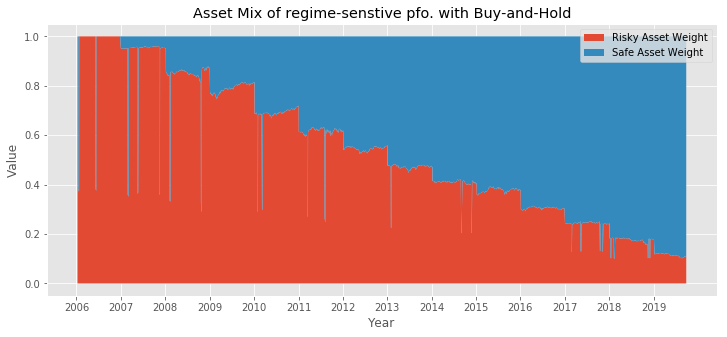

In [78]:
horizon = result_regime.index
plt.figure(figsize=(12,5))
plt.fill_between(horizon, 0, result_regime["risky asset value"]/result_regime["pfo value(regime-sensitive)"], label="Risky Asset Weight")
plt.fill_between(horizon, result_regime["risky asset value"]/result_regime["pfo value(regime-sensitive)"], 1,label="Safe Asset Weight")
plt.xticks(result.resample("BYS").first().index)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Asset Mix of regime-senstive pfo. with Buy-and-Hold")
plt.legend(loc="upper right")
plt.show()

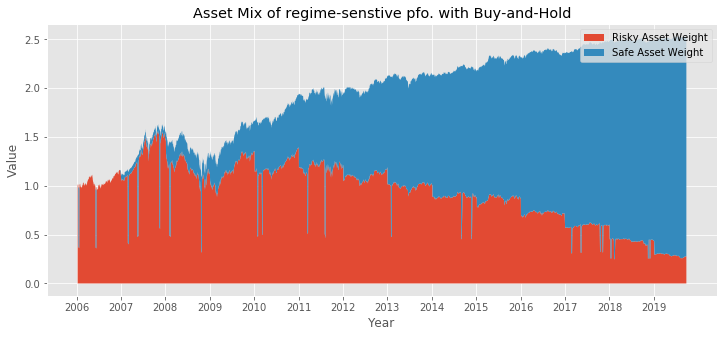

In [79]:
horizon = result_regime.index
plt.figure(figsize=(12,5))
plt.fill_between(horizon, 0, result_regime["risky asset value"], label="Risky Asset Weight")
plt.fill_between(horizon, result_regime["risky asset value"], result_regime["pfo value(regime-sensitive)"],label="Safe Asset Weight")
plt.xticks(result.resample("BYS").first().index)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Asset Mix of regime-senstive pfo. with Buy-and-Hold")
plt.legend(loc="upper right")
plt.show()

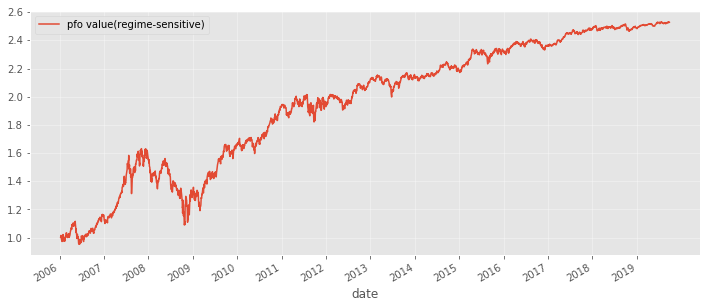

In [80]:
result_regime["pfo value(regime-sensitive)"].plot(figsize=(12,5))
plt.xticks(result_regime.resample("BYS").first().index)
plt.grid(alpha=0.4)
plt.legend()
plt.show()

In [81]:
buyandhold = pd.concat([df_allocation, fragile_boo], axis=1).fillna(method="ffill").drop(["fragile"], axis=1)
rebal_date = buyandhold[buyandhold != buyandhold.shift(1)].dropna()
rebal_date["date"] = rebal_date.index

In [82]:
date_index = weight_info.index
invest_amount = 1

result = pd.DataFrame()
for i in range(len(rebal_date)):
    start = rebal_date["date"][i]
    if i+1 != len(rebal_date):
        end = rebal_date["date"][i+1] + relativedelta(days=-1)
    else:
        end = date_index[-1]
    
    risky_amount = invest_amount * rebal_date["risky_weight"][i]
    safe_amount = invest_amount * rebal_date["safe_weight"][i]
    
    cum_risky = (1+ret_risky[start:end]).cumprod()
    cum_safe = (1+ret_safe[start:end]).cumprod()
    
    risky_value = risky_amount * cum_risky
    safe_value = safe_amount * cum_safe
    pfo_value = risky_value + safe_value
    
    result = pd.concat([result,pd.concat([risky_value, safe_value, pfo_value], axis=1)], axis=0)    
    
    invest_amount = pfo_value[-1]
result.columns = ["risky asset value", "safe asset value", "pfo value(convention)"]

result_conventional = result

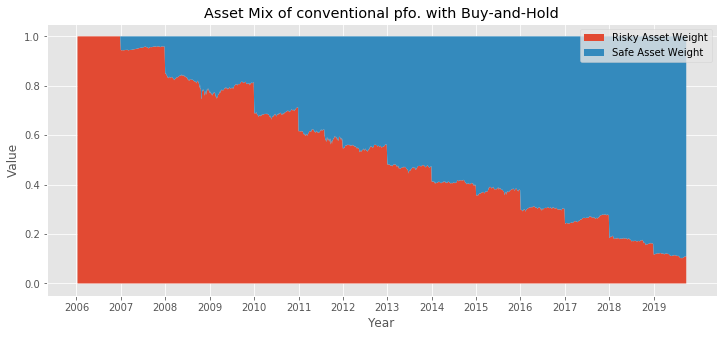

In [83]:
horizon = result_conventional.index
plt.figure(figsize=(12,5))
plt.fill_between(horizon, 0, result_conventional["risky asset value"]/result_conventional["pfo value(convention)"], label="Risky Asset Weight")
plt.fill_between(horizon, result_conventional["risky asset value"]/result_conventional["pfo value(convention)"], 1, label="Safe Asset Weight")
plt.xticks(result.resample("BYS").first().index)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Asset Mix of conventional pfo. with Buy-and-Hold")
plt.legend(loc="upper right")
plt.show()

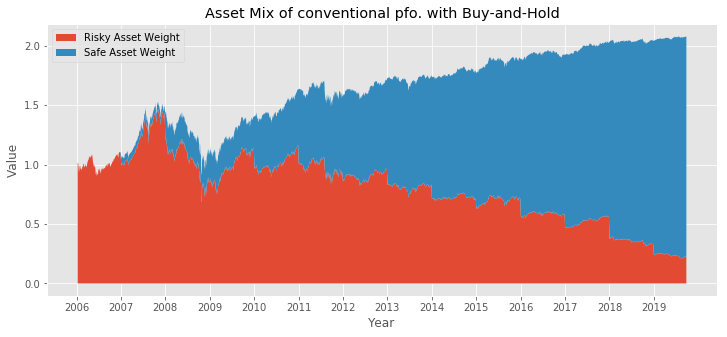

In [84]:
horizon = result_conventional.index
plt.figure(figsize=(12,5))
plt.fill_between(horizon, 0, result_conventional["risky asset value"], label="Risky Asset Weight")
plt.fill_between(horizon, result_conventional["risky asset value"], result_conventional["pfo value(convention)"], label="Safe Asset Weight")
plt.xticks(result.resample("BYS").first().index)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Asset Mix of conventional pfo. with Buy-and-Hold")
plt.legend(loc="upper left")
plt.show()

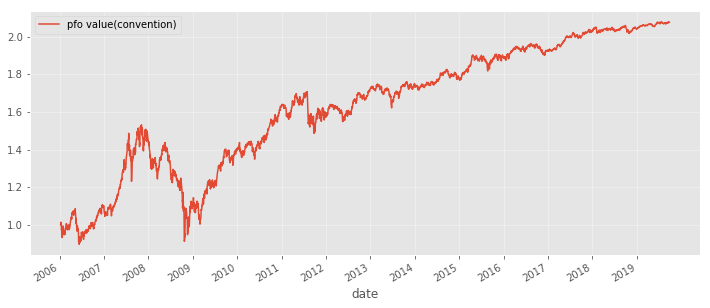

In [85]:
result_conventional["pfo value(convention)"].plot(figsize=(12,5))
plt.xticks(result_conventional.resample("BYS").first().index)
plt.grid(alpha=0.4)
plt.legend()
plt.show()

### 비교

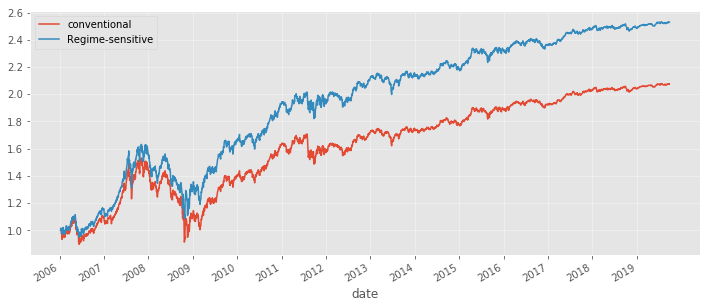

In [86]:
pfo_convention = result_conventional["pfo value(convention)"]
pfo_regime = result_regime["pfo value(regime-sensitive)"]

plt.figure(figsize=(12,5))
pfo_convention.plot(label="conventional")
pfo_regime.plot(label="Regime-sensitive")
plt.xticks(result_conventional.resample("BYS").first().index)
plt.grid(alpha=0.4)
plt.legend()
plt.show()

In [87]:
result_df2 = pd.concat([pfo_convention.pct_change(), pfo_regime.pct_change()], axis=1).dropna()
result_df2.columns = ["conventional", "regime-sensitvie"]
get_total_performance(result_df2, risk_free=0.02)

,MDD,Sharpe ratio,VaR,Profit loss ratio,Winning ratio,Calmar ratio,Mean,Std,Total return
conventional,0.403037,0.336954,-0.012655,0.947064,0.540437,0.104095,0.061954,0.124528,1.056655
regime-sensitvie,0.331601,0.460925,-0.012362,0.966546,0.542208,0.169893,0.076337,0.122244,1.505531
